## WALMART WEEKLY SALES STATISTICAL ANALYSIS

### LOAD LIBRARIES & DATA

In [151]:
#Load libraries
import numpy as np
import pandas as pd
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from matplotlib.dates import YearLocator, DateFormatter
from matplotlib.ticker import FuncFormatter
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, r2_score
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings

In [112]:
# Suppress warnings
warnings.filterwarnings("ignore")

In [113]:
#load data from source
#Data source from kraggle.com
#link: https://www.kaggle.com/datasets/mikhail1681/walmart-sales/data
df = pd.read_csv("C:/Users/DELL/Desktop/DINNO/Python_Project/Walmart_Sales_Modelling/Walmartsales.csv")

CHECK DATA INFORMATION

In [114]:
#check the data shape
df.shape

(6435, 8)

In [115]:
#check the data for duplication
if df.duplicated().any(axis=None):
    print("Duplicates found in either columns or rows.")
else:
    print("No duplication.")

No duplication.


In [116]:
# check Data types
df.dtypes

Store             int64
Date             object
Weekly_Sales    float64
Holiday_Flag      int64
Temperature     float64
Fuel_Price      float64
CPI             float64
Unemployment    float64
dtype: object

In [117]:
#View df
df.head(5)

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,5/2/2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12/2/2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,2/19/2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,2/26/2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,5/3/2010,1554806.68,0,46.50,2.625,211.350143,8.106


In [118]:
# Check for missing values
if df.isnull().values.any():
    missing_count = df.isnull().sum().sum()
    total_cells = df.size
    missing_percentage = (missing_count / total_cells) * 100

    print(f"Yes, there are {missing_count} missing values.")
    print(f"This represents {missing_percentage:.2f}% of the entire dataset.")

    # Check if missing percentage is less than 1%
    if missing_percentage < 1.0:
        # If the missing percentage is below 1%, drop rows
        df = df.dropna()
        print("Missing values dropped.")
    else:
        print("Missing percentage is greater than or equal to 1%, no rows dropped.")
else:
    print("No missing values found.")

No missing values found.


In [119]:
# Check for duplicates based on subset of columns
duplicates_before_removal = df[df.duplicated(subset=['Store', 'Date', 'Weekly_Sales', 'Fuel_Price', 'CPI', 'Unemployment'], keep=False)]

if duplicates_before_removal.empty:
    print("No duplicates found.")
else:
    total_duplicates_before = duplicates_before_removal.shape[0]  # Count the total number of duplicate rows
    total_rows_before = df.shape[0]  # Total number of rows in the DataFrame
    percentage_duplicates_before = (total_duplicates_before / total_rows_before) * 100
    print(f"Total duplicates found before removal: {total_duplicates_before}")
    print(f"Percentage of duplicates before removal: {percentage_duplicates_before:.2f}%")

    # Remove duplicates
    df.drop_duplicates(subset=['Store', 'Date', 'Weekly_Sales', 'Fuel_Price', 'CPI', 'Unemployment'], keep='first', inplace=True)

    print("Duplicates removed.")


No duplicates found.


MODIFY/CLEAN DATA

In [120]:
import pandas as pd

# Rename columns
df.rename(columns={'Store': 'StoreID', 'Unemployment': 'Unemployment_Rate'}, inplace=True)

# Convert StoreID to string
df['StoreID'] = df['StoreID'].astype(str)

# Round columns to 2 decimal places
round_columns = ['Fuel_Price', 'CPI', 'Unemployment_Rate']
df[round_columns] = df[round_columns].round(2)

# Convert Temperature from Fahrenheit to Celsius
df['Temperature'] = (df['Temperature'] - 32) * 5/9

# Convert Date to Datetime and extract date components
df['Date'] = pd.to_datetime(df['Date'])
df['Month_name'] = df['Date'].dt.month_name()
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
df['Day_Name'] = df['Date'].dt.day_name()
df['Quarter'] = df['Date'].dt.to_period("Q")

In [121]:
df.head(10)

,StoreID,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment_Rate,Month_name,Month,Year,Day_Name,Quarter
0,1,2010-05-02,1643690.90,0,5.727778,2.57,211.10,8.11,May,5,2010,Sunday,2010Q2
1,1,2010-12-02,1641957.44,1,3.616667,2.55,211.24,8.11,December,12,2010,Thursday,2010Q4
2,1,2010-02-19,1611968.17,0,4.405556,2.51,211.29,8.11,February,2,2010,Friday,2010Q1
3,1,2010-02-26,1409727.59,0,8.127778,2.56,211.32,8.11,February,2,2010,Friday,2010Q1
4,1,2010-05-03,1554806.68,0,8.055556,2.62,211.35,8.11,May,5,2010,Monday,2010Q2
5,1,2010-12-03,1439541.59,0,14.327778,2.67,211.38,8.11,December,12,2010,Friday,2010Q4
6,1,2010-03-19,1472515.79,0,12.544444,2.72,211.22,8.11,March,3,2010,Friday,2010Q1
7,1,2010-03-26,1404429.92,0,10.805556,2.73,211.02,8.11,March,3,2010,Friday,2010Q1
8,1,2010-02-04,1594968.28,0,16.816667,2.72,210.82,7.81,February,2,2010,Thursday,2010Q1
9,1,2010-09-04,1545418.53,0,18.811111,2.77,210.62,7.81,September,9,2010,Saturday,2010Q3


In [122]:
# View Data Stats
df.describe()

,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment_Rate,Month,Year
count,6435,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000
mean,2011-06-17 20:18:27.692307712,1.046965e+06,0.069930,15.924324,3.358620,171.578468,7.998831,6.475524,2010.965035
min,2010-01-10 00:00:00,2.099862e+05,0.000000,-18.922222,2.470000,126.060000,3.880000,1.000000,2010.000000
25%,2010-10-12 00:00:00,5.533501e+05,0.000000,8.588889,2.930000,131.740000,6.890000,4.000000,2010.000000
50%,2011-06-17 00:00:00,9.607460e+05,0.000000,17.038889,3.440000,182.620000,7.870000,6.000000,2011.000000
75%,2012-03-02 00:00:00,1.420159e+06,0.000000,23.855556,3.740000,212.745000,8.620000,9.000000,2012.000000
max,2012-12-10 00:00:00,3.818686e+06,1.000000,37.855556,4.470000,227.230000,14.310000,12.000000,2012.000000
std,NaN,5.643666e+05,0.255049,10.247185,0.459097,39.356697,1.876046,3.321797,0.797019


In [123]:
# Define and store the FuncFormatter for y axis value and use when needed

from matplotlib.ticker import FuncFormatter

def format_func(value, tick_number):
    if value >= 1_000_000:
        value /= 1_000_000
        return f'${value:.0f}M'
    elif value >= 1_000:
        value /= 1_000
        return f'${value:.0f}K'
    else:
        return f'${value:.0f}'

## UNIVARIATE ANALYSIS 

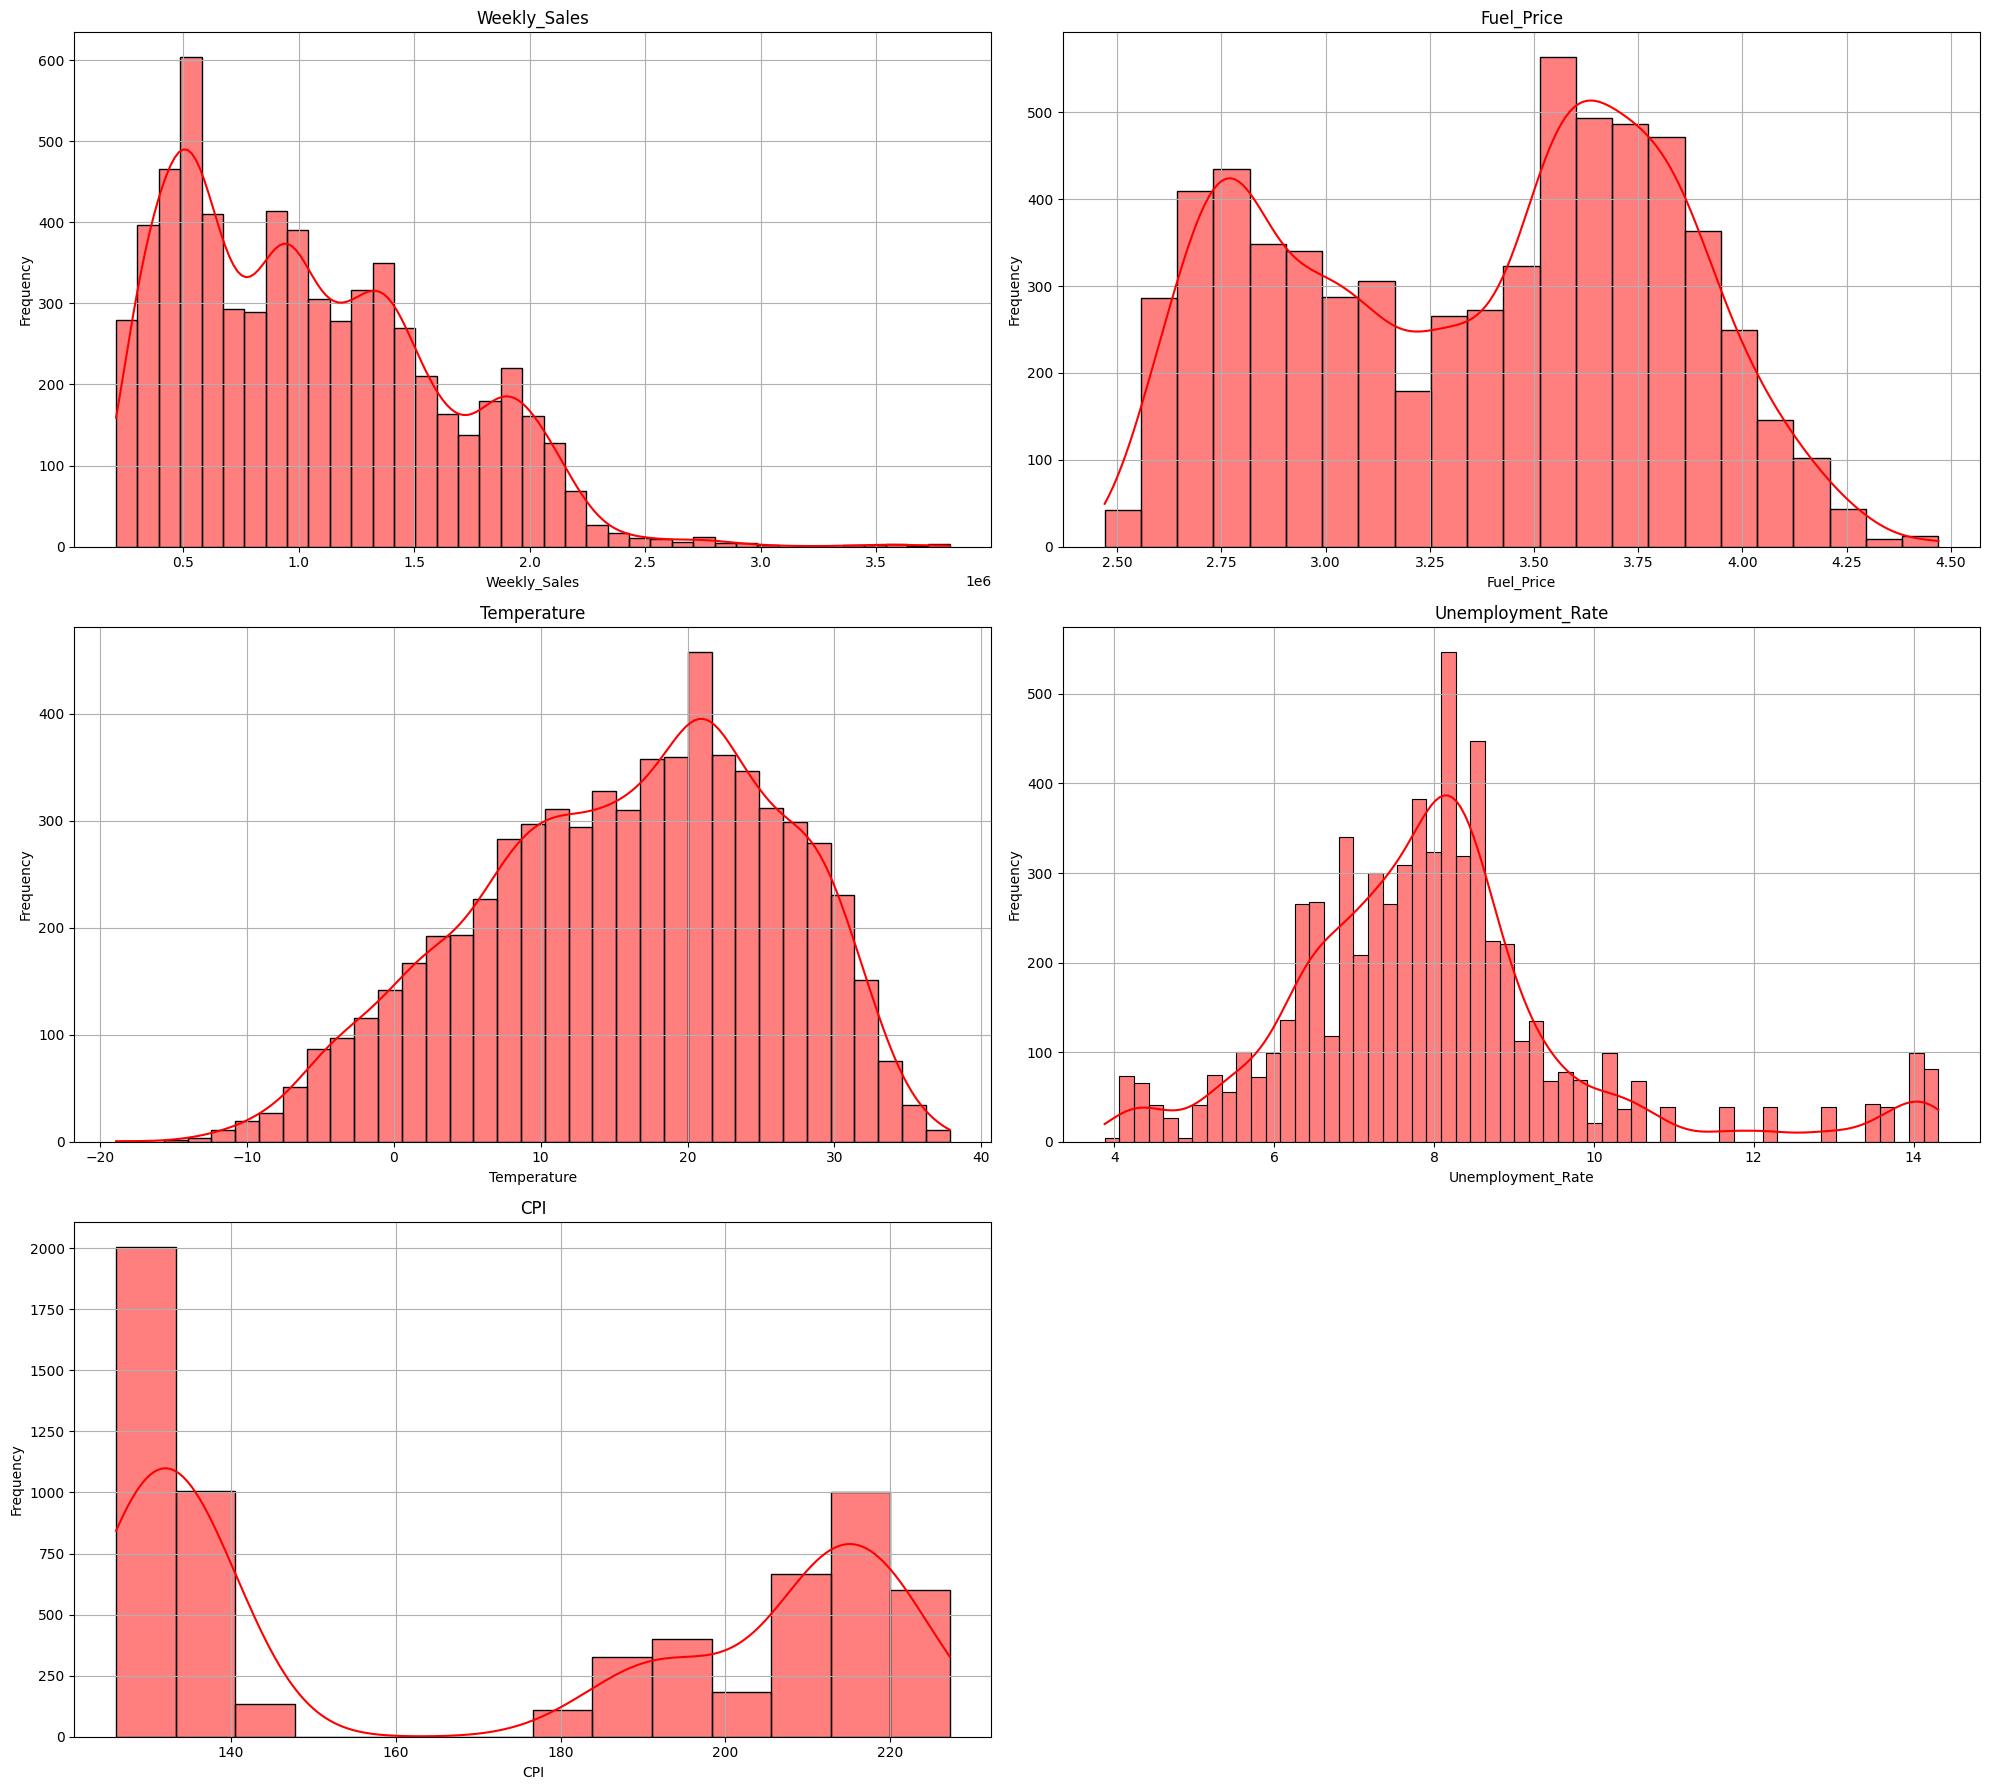

In [125]:
# Histogram to check the distribution of variables 
# Columns for histograms
columns = ['Weekly_Sales', 'Fuel_Price', 'Temperature', 'Unemployment_Rate', 'CPI']

# Calculate the number of rows and columns for the subplot grid
num_plots = len(columns)
num_rows = (num_plots + 1) // 2
num_cols = min(2, num_plots)

# Create a subplot grid
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(10 * num_cols, 6 * num_rows))

# Flatten the axes
axes = axes.flatten()

# Plot histograms for each column
for i, column in enumerate(columns):
    sns.histplot(df[column], kde=True, ax=axes[i], color='red', edgecolor='black')
    axes[i].set_title(f'{column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')
    axes[i].grid(True)

# Remove empty subplots if there are any
for j in range(num_plots, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()


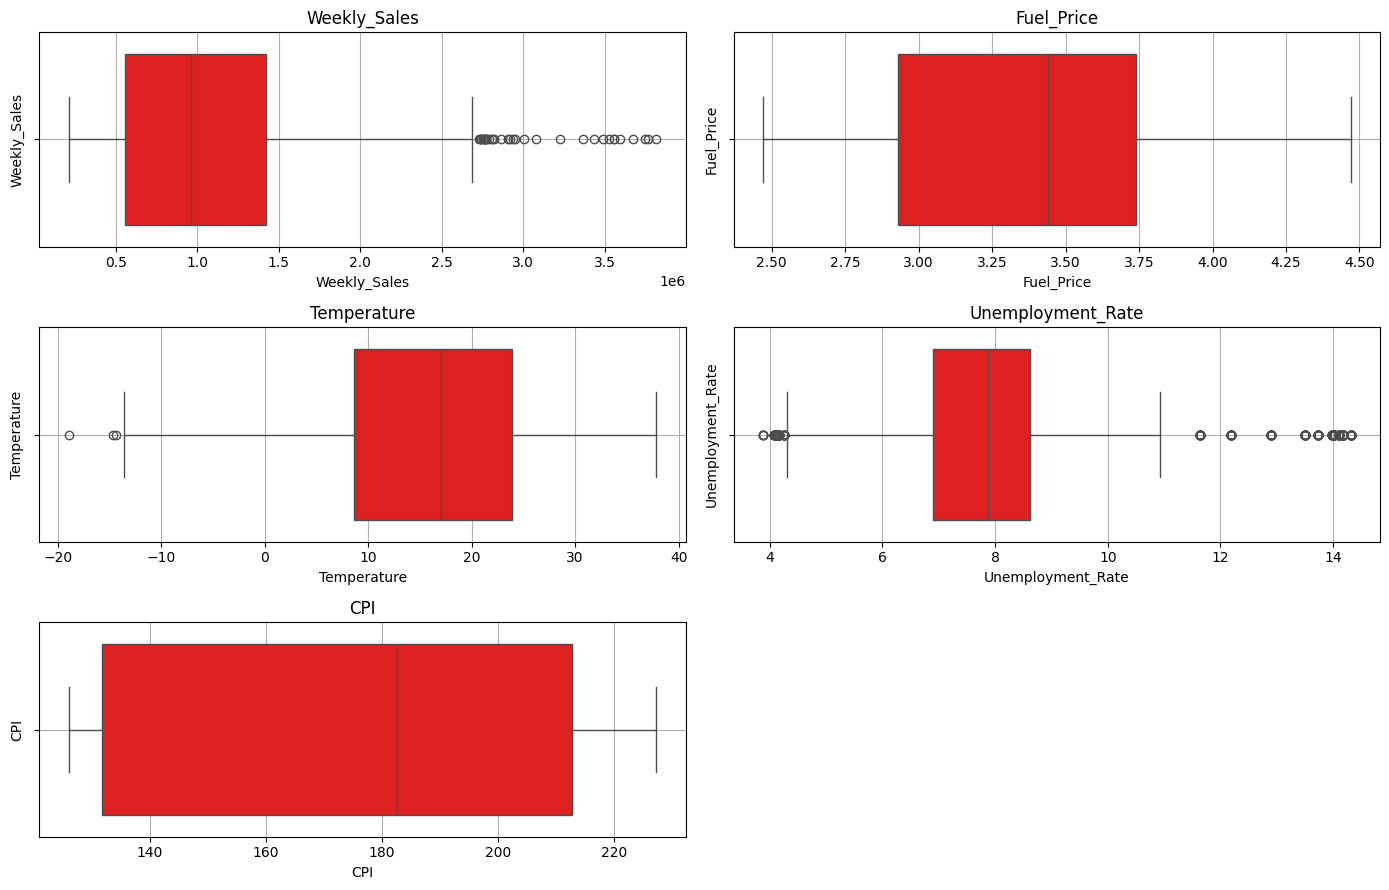

In [126]:
# Box plot to check for outliers
# Create a subplot grid
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(7 * num_cols, 3 * num_rows))

# Flatten the axes
axes = axes.flatten()

# Plot boxplots for each column
for i, column in enumerate(columns):
    sns.boxplot(data=df[column], ax=axes[i], orient='h', color = 'red')
    axes[i].set_title(f'{column}')
    axes[i].set_ylabel(column)
    axes[i].grid(True)

# Remove empty subplots if there are any
for j in range(num_plots, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()


## BIVARIATE ANALYSIS

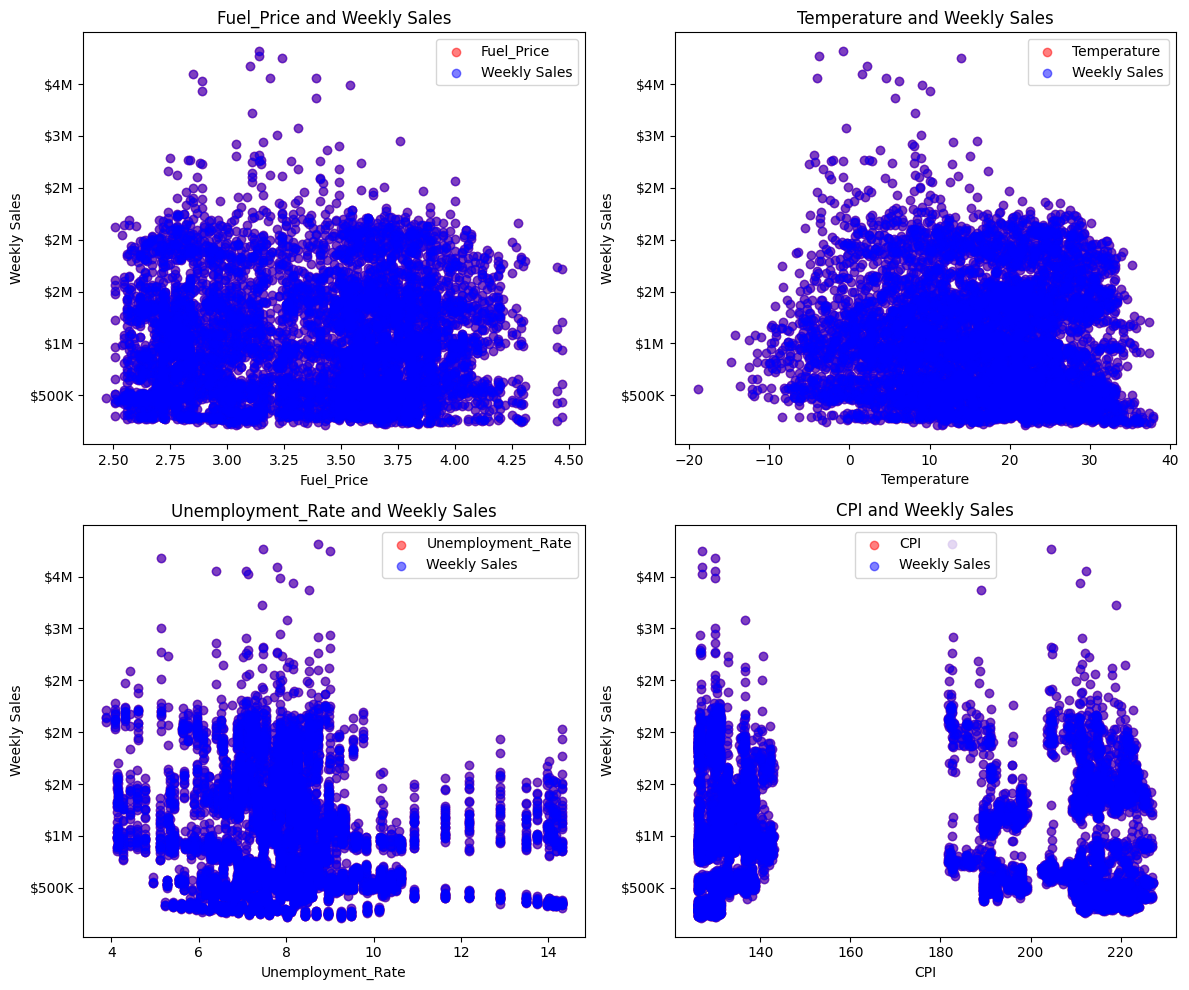

In [127]:
# scattered Plot to show the relationship between Dependents and Featured variables
# Create a 2x2 subplot grid
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

# Features to plot
features = ['Fuel_Price', 'Temperature', 'Unemployment_Rate', 'CPI']

# Plot scatter plots for each feature
for i, feature in enumerate(features):
    row = i // 2  # Row index
    col = i % 2   # Column index
    
    # Scatter plot for features in red
    axes[row, col].scatter(df[feature], df['Weekly_Sales'], color='red', alpha=0.5, label=feature)
    
    # Scatter plot for dependent variable in blue
    axes[row, col].scatter(df[feature], df['Weekly_Sales'], color='blue', alpha=0.5, label='Weekly Sales')
    
    axes[row, col].set_title(f'{feature} and Weekly Sales')
    axes[row, col].set_xlabel(feature)
    axes[row, col].set_ylabel('Weekly Sales')
    axes[row, col].legend()
    
    # Apply the formatter to the y-axis
    axes[row, col].yaxis.set_major_formatter(FuncFormatter(format_func))

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


## TREND ANALYSIS

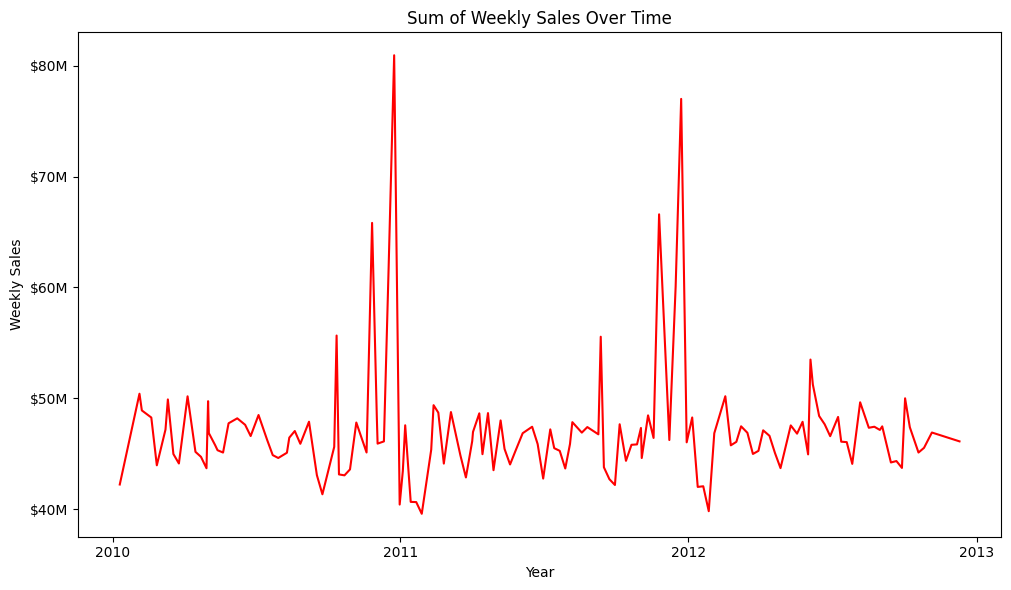

In [ ]:
# WEEKLY SALES TREND OVER TIME

# Group by 'Date' and sum up 'Weekly_Sales' for each unique date
d_df = df.groupby('Date')['Weekly_Sales'].sum().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(d_df['Date'], d_df['Weekly_Sales'], color='red')
plt.title('Sum of Weekly Sales Over Time')
plt.xlabel('Year')
plt.ylabel('Weekly Sales')
plt.tight_layout()

# Set x-axis to display only years
plt.gca().xaxis.set_major_locator(YearLocator())
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y'))

# Apply the formatter to the y-axis
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_func))

# Save the figure
plt.savefig('weekly_sales_analysis.png')
plt.show()


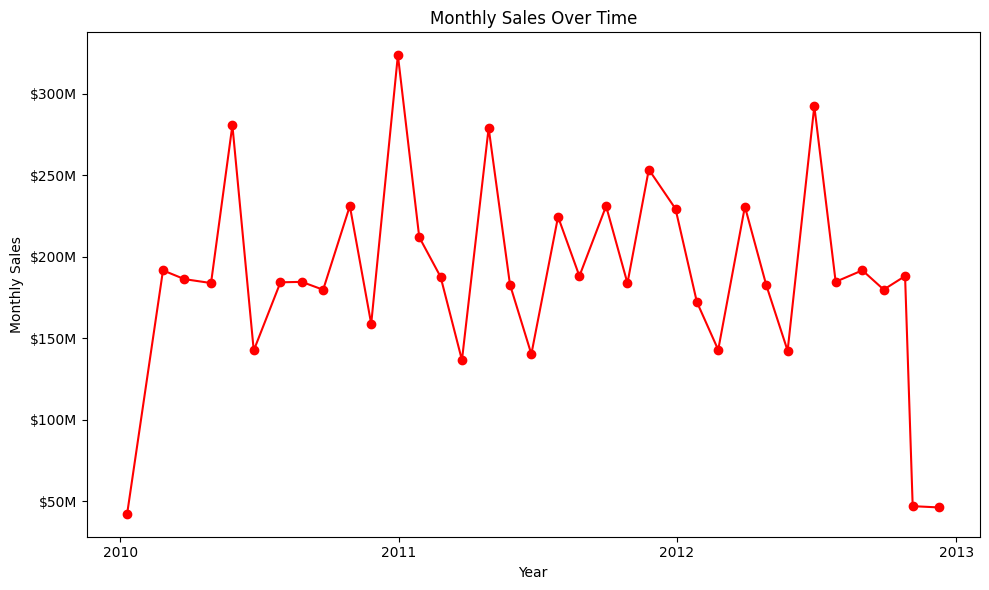

In [128]:
# MONTHLY SALES TREND OVERTIME

# Group by year and month and find the last date of each month
last_dates = df.groupby([df['Date'].dt.year, df['Date'].dt.month])['Date'].max()

# Create a list to store the result
result_data = []

# Iterate over the last dates and calculate the mean of sales, fuel price, temperature, unemployment, and CPI for each month
for year, month in last_dates.index:
    last_date = last_dates.loc[year, month]
    monthly_data = df[(df['Date'].dt.year == year) & (df['Date'].dt.month == month)]
    monthly_sales = monthly_data['Weekly_Sales'].sum()
    avg_fuel_price = monthly_data['Fuel_Price'].mean()
    avg_temperature = monthly_data['Temperature'].mean()
    avg_unemployment = monthly_data['Unemployment_Rate'].mean()
    avg_cpi = monthly_data['CPI'].mean()
    result_data.append({'Date': last_date, 'Monthly_Sales': monthly_sales, 
                        'Average_Fuel_Price': avg_fuel_price, 'Average_Temperature': avg_temperature,
                        'Average_Unemployment_Rate': avg_unemployment, 'Average_CPI': avg_cpi})

# Create a DataFrame from the list
trend_df = pd.DataFrame(result_data)

# Plotting trend of monthly sales per year
plt.figure(figsize=(10, 6))
plt.plot(trend_df['Date'], trend_df['Monthly_Sales'], marker = 'o', color = 'red')
plt.title('Monthly Sales Over Time')
plt.xlabel('Year')
plt.ylabel('Monthly Sales')
plt.grid(False)

# Set x-axis to display only years
plt.gca().xaxis.set_major_locator(YearLocator())
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y'))

# Apply the formatter to the y-axis
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_func))

plt.tight_layout()
plt.show()


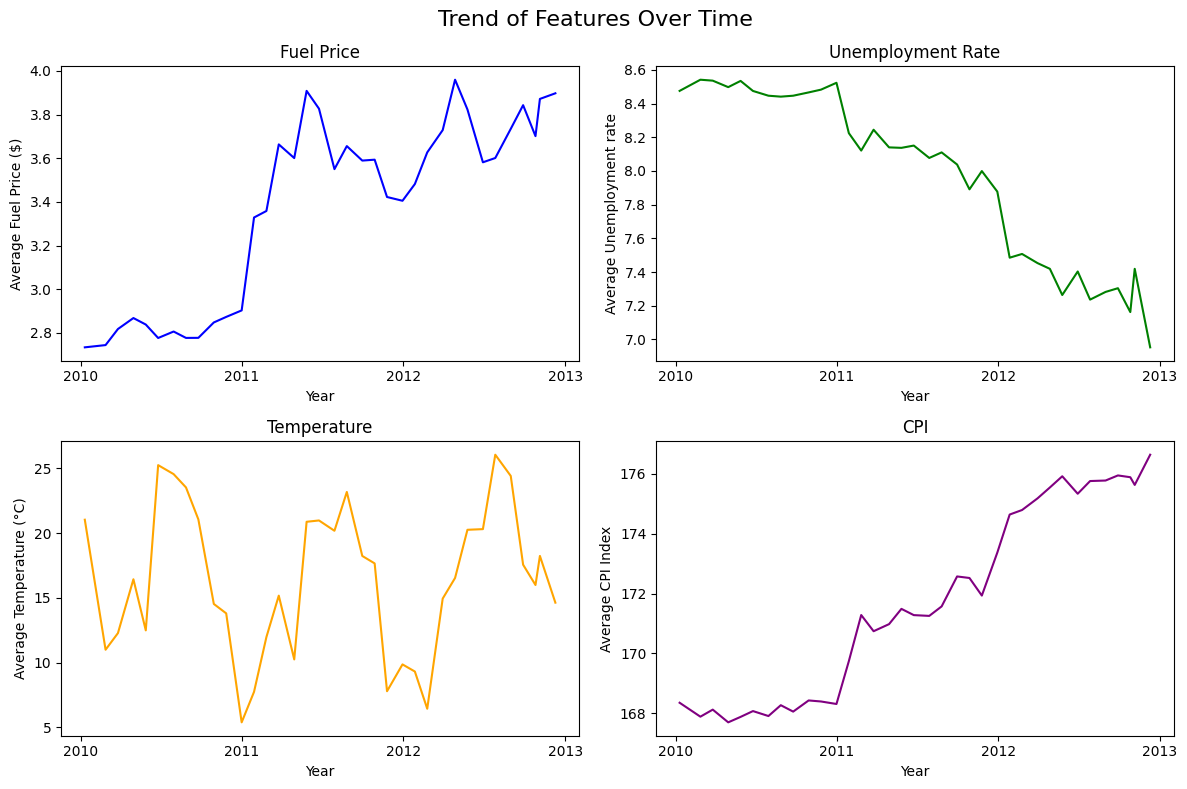

In [139]:
# TREND OF FEATURED VARIABLES OVERTIME

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Plot each variable on a separate subplot
axs[0, 0].plot(trend_df['Date'], trend_df['Average_Fuel_Price'], color='blue')
axs[0, 0].set_title('Fuel Price')
axs[0, 0].set_ylabel('Average Fuel Price ($)')

axs[0, 1].plot(trend_df['Date'], trend_df['Average_Unemployment_Rate'], color='green')
axs[0, 1].set_title('Unemployment Rate')
axs[0, 1].set_ylabel('Average Unemployment rate')

axs[1, 0].plot(trend_df['Date'], trend_df['Average_Temperature'], color='orange')
axs[1, 0].set_title('Temperature')
axs[1, 0].set_ylabel('Average Temperature (°C)')

axs[1, 1].plot(trend_df['Date'], trend_df['Average_CPI'], color='purple')
axs[1, 1].set_title('CPI')
axs[1, 1].set_ylabel('Average CPI Index')

# Set common labels and grid
for ax in axs.flat:
    ax.set(xlabel='Year')
    ax.grid(False)
    ax.xaxis.set_major_locator(YearLocator())
    ax.xaxis.set_major_formatter(DateFormatter('%Y'))

# Add a title for the entire plot
fig.suptitle('Trend of Features Over Time', fontsize=16)

# Adjust layout and display
plt.tight_layout()
plt.show()



## CORRELATION ANALYSIS

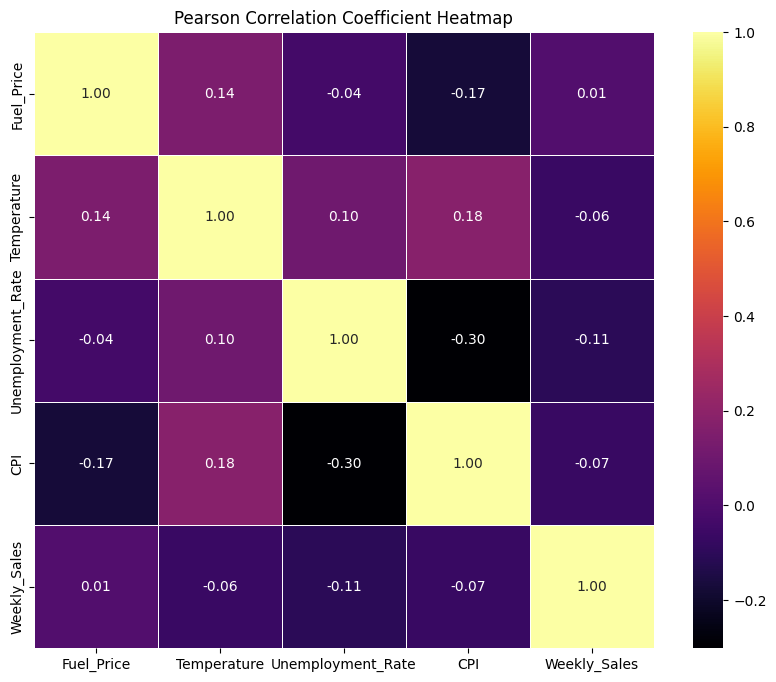

In [130]:
# Correlation analysis between variables
# Select Features
rl = ['Fuel_Price', 'Temperature', 'Unemployment_Rate', 'CPI', 'Weekly_Sales']

# Calculate correlation matrix
corr_matrix = df[rl].corr()

# Calculate p-values for correlation coefficients
p_values = pd.DataFrame(index=corr_matrix.index, columns=corr_matrix.columns)
for i in corr_matrix.index:
    for j in corr_matrix.columns:
        corr, p_value = pearsonr(df[i], df[j])
        p_values.loc[i, j] = p_value

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='inferno', fmt=".2f", linewidths=0.5)              
plt.title('Pearson Correlation Coefficient Heatmap')
plt.show()


# Predictive Modeling of Weekly Sales

### Data Preprocessing 

In [131]:
#Create df with variables 
predict_df = df[['Date', 'Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment_Rate']]

# Set Date as the index
predict_df.set_index('Date', inplace=True)

In [132]:
predict_df.head(5)

,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment_Rate
Date,,,,,
2010-05-02,1643690.90,5.727778,2.57,211.10,8.11
2010-12-02,1641957.44,3.616667,2.55,211.24,8.11
2010-02-19,1611968.17,4.405556,2.51,211.29,8.11
2010-02-26,1409727.59,8.127778,2.56,211.32,8.11
2010-05-03,1554806.68,8.055556,2.62,211.35,8.11


In [133]:
# Scale Predict_df
# Select the numerical and featured variables columns for scaling
numerical_columns = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment_Rate']
scale = predict_df[numerical_columns]

# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform the data
scaled_data = scaler.fit_transform(scale)

# Create DataFrame with the scaled data
scaled_df = pd.DataFrame(scaled_data, columns=numerical_columns, index=predict_df.index)

# Combining the scaled numerical data with non-numerical columns
predict_df_scaled = pd.concat([scaled_df, predict_df.drop(columns=numerical_columns)], axis=1)


In [134]:
predict_df_scaled.head(5)

,Temperature,Fuel_Price,CPI,Unemployment_Rate,Weekly_Sales
Date,,,,,
2010-05-02,-0.995136,-1.717898,1.004266,0.059261,1643690.90
2010-12-02,-1.201170,-1.761465,1.007824,0.059261,1641957.44
2010-02-19,-1.124178,-1.848599,1.009094,0.059261,1611968.17
2010-02-26,-0.760907,-1.739681,1.009857,0.059261,1409727.59
2010-05-03,-0.767955,-1.608980,1.010619,0.059261,1554806.68


# Check for Multicollinarity between Independent Variables

In [143]:
# Check with Correlation Matrix
# Set the threshold for multicollinearity
threshold = 0.7

# Calculate correlation matrix between independent variables
correlation_matrix = predict_df_scaled.drop(columns=['Weekly_Sales']).corr()

# Check for multicollinearity
multicollinearity = (correlation_matrix > threshold) & (correlation_matrix < 1)

# Print results
print("Multicollinearity Result for each independent variable:")
for col in multicollinearity.columns:
    correlated_cols = multicollinearity[col][multicollinearity[col]].index.tolist()
    if len(correlated_cols) > 0:
        print(f"Variables highly correlated with '{col}': {', '.join(correlated_cols)}")
    else:
        print(f"No multicollinearity detected for '{col}'.")

Multicollinearity Result for each independent variable:
No multicollinearity detected for 'Temperature'.
No multicollinearity detected for 'Fuel_Price'.
No multicollinearity detected for 'CPI'.
No multicollinearity detected for 'Unemployment_Rate'.


In [136]:
# Ascertain with Variance Inflation Factor (VIF)
# Select independent variables
multcol = predict_df_scaled.drop(columns=['Weekly_Sales'])

# Reset index
multcol.reset_index(drop=True, inplace=True)

# Calculate VIF for each independent variable
vif_data = pd.DataFrame()
vif_data["Variable"] = multcol.columns
vif_data["VIF"] = [variance_inflation_factor(multcol.values, i) for i in range(multcol.shape[1])]

# Check if VIF < 5
vif_data['Multicollinearity'] = np.where(vif_data['VIF'] < 5, 'No', 'Yes')

# Print VIF for each variable
print("Variance Inflation Factor (VIF) for each independent variable:")
print(vif_data)


Variance Inflation Factor (VIF) for each independent variable:
            Variable       VIF Multicollinearity
0        Temperature  1.104939                No
1         Fuel_Price  1.081745                No
2                CPI  1.220793                No
3  Unemployment_Rate  1.149246                No


# Modeling

In [153]:
# Perform grid search to and select the best 

# Define features and target variable
X = predict_df_scaled.drop(columns=['Weekly_Sales'])
y = predict_df_scaled['Weekly_Sales']

# Train-test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize polynomial regression pipeline
poly_reg = make_pipeline(PolynomialFeatures(), LinearRegression())

# Define parameters for grid search
param_grid = {'polynomialfeatures__degree': [2, 3, 4, 5]}  # You can adjust the degree range as needed

# Define custom scorer for GridSearchCV based on R^2 score
scorer = make_scorer(r2_score)

# Perform grid search
grid_search = GridSearchCV(poly_reg, param_grid, cv=5, scoring={'mse': 'neg_mean_squared_error', 'r2': scorer}, refit='r2')
grid_search.fit(X_train, y_train)

# Print grid search results
print("Grid Search Results:")
print()
results_df = pd.DataFrame(grid_search.cv_results_)
print(results_df[['param_polynomialfeatures__degree', 'mean_test_mse', 'std_test_mse', 'rank_test_mse', 'mean_test_r2', 'std_test_r2', 'rank_test_r2']])


# Get and display the best polynomial degree
best_degree = grid_search.best_params_['polynomialfeatures__degree']
print("\nBest Polynomial Degree:", best_degree)


Grid Search Results:

  param_polynomialfeatures__degree  mean_test_mse  std_test_mse  \
0                                2  -3.042711e+11  1.009746e+10   
1                                3  -2.874501e+11  9.143930e+09   
2                                4  -2.759495e+11  7.319673e+09   
3                                5  -2.708244e+11  9.675079e+09   

   rank_test_mse  mean_test_r2  std_test_r2  rank_test_r2  
0              4      0.041381     0.007294             4  
1              3      0.094294     0.011574             3  
2              2      0.130368     0.013008             2  
3              1      0.146608     0.021094             1  

Best Polynomial Degree: 5


In [156]:
# Define features and target variable
X = predict_df_scaled.drop(columns=['Weekly_Sales'])
y = predict_df_scaled['Weekly_Sales']

# Train-test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize polynomial regression pipeline
degree = 5
poly_reg = make_pipeline(PolynomialFeatures(degree), LinearRegression())

# Initialize models
models = {
    'Polynomial Regression': poly_reg,
    'Random Forest': RandomForestRegressor(random_state=42),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'Support Vector Regression': SVR()
}

# Train and evaluate models
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[name] = {'MSE': mse, 'R2': r2}

# Display results
for name, result in results.items():
    print(f"Model: {name}")
    print(f"MSE: {result['MSE']}")
    print(f"R^2: {result['R2']}")
    print()



Model: Polynomial Regression
MSE: 271604240153.53253
R^2: 0.15691326471711742

Model: Random Forest
MSE: 287723980645.8611
R^2: 0.10687597745826538

Model: Decision Tree
MSE: 395104691228.245
R^2: -0.22644449156711732

Model: Gradient Boosting
MSE: 246872444752.86743
R^2: 0.23368323204253283

Model: Support Vector Regression
MSE: 331333734716.7903
R^2: -0.028493062308439177



Model: Polynomial Regression
Model: Random Forest
Model: Decision Tree
Model: Gradient Boosting
Model: Support Vector Regression


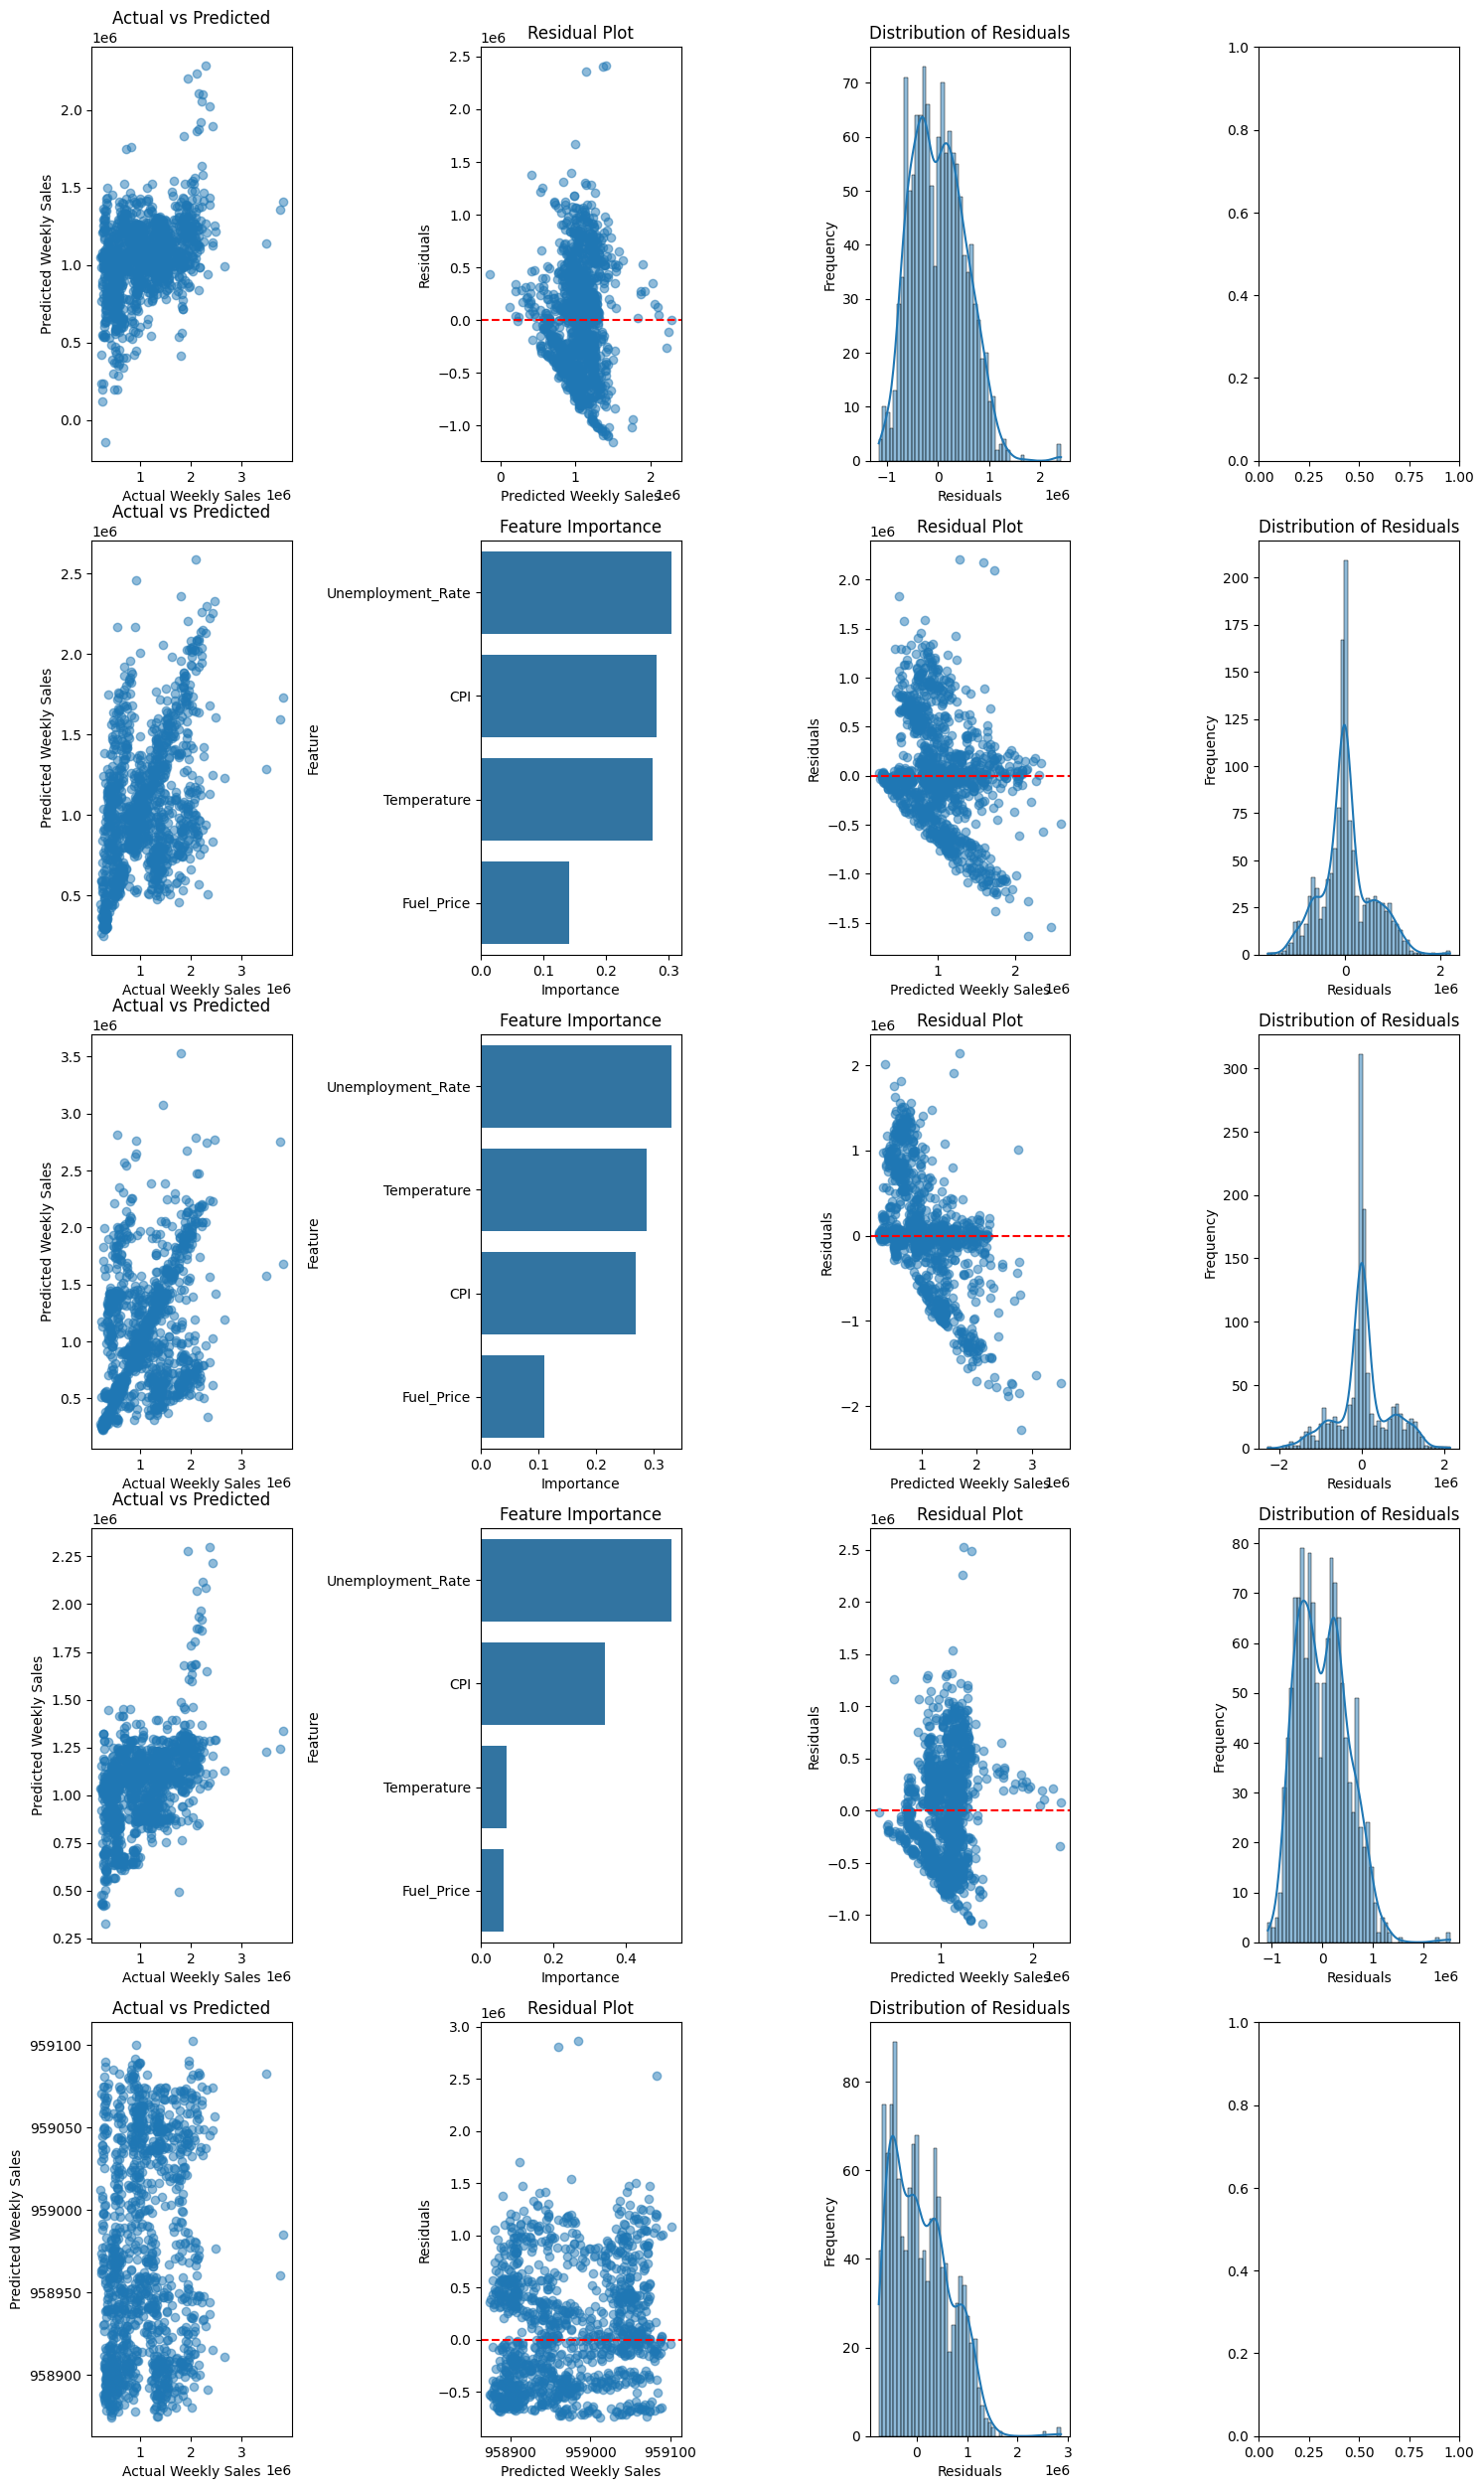

In [155]:
#Visualise model parameters
def visualize_model_subplot(model, X_test, y_test, ax):
    # Actual vs Predicted plot
    y_pred = model.predict(X_test)
    ax[0].scatter(y_test, y_pred, alpha=0.5)
    ax[0].set_xlabel('Actual Weekly Sales')
    ax[0].set_ylabel('Predicted Weekly Sales')
    ax[0].set_title('Actual vs Predicted')

    # Feature importance (for tree-based models)
    if hasattr(model, 'feature_importances_'):
        importance = model.feature_importances_
        feature_names = X_test.columns
        importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
        importance_df = importance_df.sort_values(by='Importance', ascending=False)
        sns.barplot(ax=ax[1], x='Importance', y='Feature', data=importance_df)
        ax[1].set_title('Feature Importance')

        # Residual plot
        residuals = y_test - y_pred
        ax[2].scatter(y_pred, residuals, alpha=0.5)
        ax[2].set_xlabel('Predicted Weekly Sales')
        ax[2].set_ylabel('Residuals')
        ax[2].set_title('Residual Plot')
        ax[2].axhline(y=0, color='r', linestyle='--')

        # Distribution of residuals
        sns.histplot(residuals, bins=50, kde=True, ax=ax[3])
        ax[3].set_xlabel('Residuals')
        ax[3].set_ylabel('Frequency')
        ax[3].set_title('Distribution of Residuals')
    else:
        # Residual plot
        residuals = y_test - y_pred
        ax[1].scatter(y_pred, residuals, alpha=0.5)
        ax[1].set_xlabel('Predicted Weekly Sales')
        ax[1].set_ylabel('Residuals')
        ax[1].set_title('Residual Plot')
        ax[1].axhline(y=0, color='r', linestyle='--')

        # Distribution of residuals
        sns.histplot(residuals, bins=50, kde=True, ax=ax[2])
        ax[2].set_xlabel('Residuals')
        ax[2].set_ylabel('Frequency')
        ax[2].set_title('Distribution of Residuals')

# Create subplots
fig, axs = plt.subplots(len(models), 4, figsize=(15, len(models)*5))

# Visualize each model
for i, (name, model) in enumerate(models.items()):
    print(f"Model: {name}")
    visualize_model_subplot(model, X_test, y_test, axs[i])

# Adjust layout
plt.tight_layout()
plt.show()


## Hypothesis Testing

In [157]:
# Adopt GLM for hypothesis testing
# Add constant to the features for the intercept term
X_train_with_const = sm.add_constant(X_train)

# Fit the multiple regression model
polynomial_regression_model = sm.GLM(y_train, X_train_with_const, family=sm.families.Gaussian()).fit()

# Get the summary of the regression model
print(polynomial_regression_model.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:           Weekly_Sales   No. Observations:                 5148
Model:                            GLM   Df Residuals:                     5143
Model Family:                Gaussian   Df Model:                            4
Link Function:               Identity   Scale:                      3.0961e+11
Method:                          IRLS   Log-Likelihood:                -75407.
Date:                Mon, 29 Apr 2024   Deviance:                   1.5923e+15
Time:                        23:14:21   Pearson chi2:                 1.59e+15
No. Iterations:                     3   Pseudo R-squ. (CS):            0.02615
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              1.045e+06   7756.44

## Thank You for Your Time